# Segmentation with U-Net + Prediction Proyect (BWH)

# 1) U-Net Structure

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import SimpleITK as sitk
%matplotlib inline

In [6]:
from keras.models import Model, model_from_json
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout, Activation, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy, mean_absolute_error, fbeta_score, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
from keras import backend as K
from keras.utils.np_utils import to_categorical

------------------

## Reading Data

CTSlices Shape: 
(1455, 512, 512)
Labels Shape: 
(1455, 512, 512)


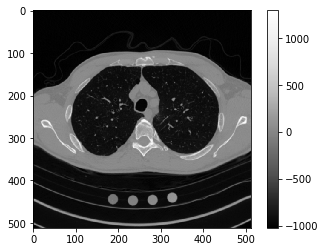

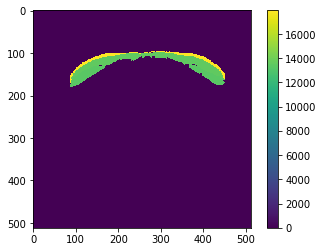

[    0 13335 13336 13591 13592 17943 17944]


In [4]:
folder = '/home/rmoreta/Projects/PectoralisSegmentation/Data/ProjectData_clean/'
num_files = [0] # 7 nrrd files in total

CTSlices = []
labels = []
# Reading CT

for i in num_files:
    if i == num_files[0]:
        # CTSlices
        file_name_CT = 'Cont_' + str(i+1) + '_clean.nrrd'#'_clean.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_CT)
        CTSlices = sitk.GetArrayFromImage(image_nrrd)
        # Labels
        file_name_label = 'Cont_lm_' + str(i+1) + '_clean.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_label)
        labels = sitk.GetArrayFromImage(image_nrrd)
    else:
        # CTSlices
        file_name_CT = 'Cont_' + str(i+1) + '_clean.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_CT)
        CTSlices_aux = sitk.GetArrayFromImage(image_nrrd)
        CTSlices = np.concatenate((CTSlices, CTSlices_aux), axis = 0)
        # Labels
        file_name_label = 'Cont_lm_' + str(i+1) + '_clean.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_label)
        labels_aux = sitk.GetArrayFromImage(image_nrrd)
        labels = np.concatenate((labels, labels_aux), axis = 0)
        
print('CTSlices Shape: ')
print(CTSlices.shape)

print('Labels Shape: ')
print(labels.shape)

# num_labels = np.unique(labels)

# Image Representation
slice_num = 300
ToraxSlice = CTSlices[slice_num,:,:]
plt.figure()
plt.imshow(ToraxSlice,cmap='Greys_r')
plt.colorbar()
plt.show()

LabelToraxSlice = labels[slice_num,:,:]
plt.figure()
plt.imshow(LabelToraxSlice)
plt.colorbar()
plt.show()
print(np.unique(LabelToraxSlice))

------------------

## Pre-Processing Data

**Normalizing**

In [7]:
numpy_array = CTSlices.astype(np.float32)
numpy_array[numpy_array < -1024] = -1024
numpy_array[numpy_array > 1500] = 1500
numpy_array = (numpy_array + 1024) / (1500 + 1024) - 0.5

CTSlices_new = numpy_array
print(CTSlices_new.shape)

(1455, 512, 512)


**Selecting Labels**

Pectorals Labels

In [4]:
num_classes = 3

array([0, 1, 2, 3, 4], dtype=int16)

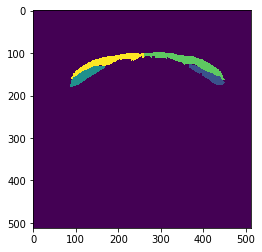

In [8]:
num_classes = 5

labels[(labels!=13335)&(labels!=13336)&(labels!=13591)&(labels!=13592)&(labels!=17943)&(labels!=17944)] = 0
labels[(labels==13335)] = 1 # Left Minor Pectoral
labels[(labels==13336)] = 2 # Right Minor Pectoral
labels[(labels==13591)] = 3 # Left Major Pectoral
labels[(labels==13592)] = 4 # RIght Major Pectoral
labels[(labels==17943)] = 0 # Left Fat 
labels[(labels==17944)] = 0 # Right Fat 
plt.figure()
plt.imshow(labels[slice_num,:,:])
np.unique(labels[slice_num,:,:])

In [6]:
#plt.figure()
#plt.imshow(labels[300,:,:])
#plt.savefig('Figures/Multiclass/lables_example.png')

(1455, 512, 512, 5)


/home/rmoreta/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


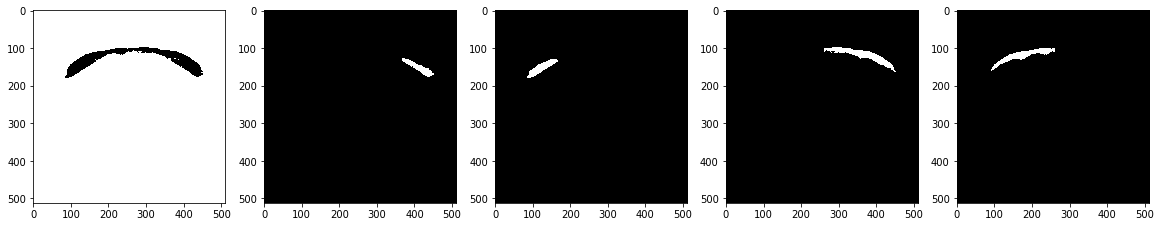

In [9]:
labels_cat = (np.arange(num_classes) == labels[:,:,:,None])
print(labels_cat.shape)

f, a = plt.subplots(1, num_classes, figsize=(20, 20))
for i in range(num_classes):
    a[i].imshow(labels_cat[slice_num,:,:,i],cmap='Greys_r')
f.show()
plt.draw()

In [8]:
#f.savefig('Figures/Multiclass/subplot_lables.png')

Fat

In [9]:
#labels[(labels!=17943)&(labels!=17944)] = 0
#labels[(labels==17943)] = 1 # Right Fat (image)
#labels[(labels==17944)] = 1 # Left Fat (image)
#plt.figure()
#plt.imshow(labels[slice_num,:,:])
#np.unique(labels[slice_num,:,:])

-----------------

## Spliting data in Training And Testing

In [7]:
img_rows = 352 # Divisible por 16
img_cols = 304
auxi = 512-img_cols

In [23]:
num_images_train = 1400
num_images_test = 35

train_dataset = CTSlices_new[0 : num_images_train,0:img_rows, auxi:]
train_labels = labels_cat[0 : num_images_train,0:img_rows,auxi:]
test_dataset = CTSlices_new[num_images_train : num_images_train+num_images_test,0:img_rows, auxi:]
test_labels = labels_cat[num_images_train : num_images_train+num_images_test,0:img_rows, auxi:]

print(train_dataset.shape)
print(train_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)

(1400, 352, 304)
(1400, 352, 304, 4)
(35, 352, 304)
(35, 352, 304, 4)


In [10]:
img_rows = 512 # Divisible por 16
img_cols = 512

In [11]:
num_images_train = 1400
num_images_test = 100

train_dataset = CTSlices_new[0 : num_images_train,:,:]
train_labels = labels_cat[0 : num_images_train,:,:]
test_dataset = CTSlices_new[num_images_train : num_images_train+num_images_test,:,:]
test_labels = labels_cat[num_images_train : num_images_train+num_images_test,:,:]

print(train_dataset.shape)
print(train_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)

(1400, 512, 512)
(1400, 512, 512, 5)
(55, 512, 512)
(55, 512, 512, 5)


In [9]:
num_images_train = 1400
num_images_test = 1000

train_dataset = CTSlices_new[0 : num_images_train,:,:]
train_labels = labels[0 : num_images_train,:,:]
test_dataset = CTSlices_new[num_images_train : num_images_train+num_images_test,:,:]
test_labels = labels[num_images_train : num_images_train+num_images_test,:,:]

print(train_dataset.shape)
print(train_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)

(1400, 512, 512)
(1400, 512, 512)
(1000, 512, 512)
(1000, 512, 512)


--------------

## U-net Structure

**Loss Functions**

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

**Accuracy**

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

In [12]:
def IoU(y_true, y_pred):
    #y_true = K.flatten(y_true)
    #y_pred = K.flatten(y_pred)
    y_true = K.round(K.clip(y_true, 0, 1))
    y_pred = K.round(K.clip(y_pred, 0, 1))
    
    tp = K.sum(y_true * y_pred)
    print(tp.get_shape().as_list())
    fn = K.sum((y_true + y_pred)*y_true) - tp*2.
    fp = K.sum((y_true + y_pred)*y_pred) - tp*2.

    IoU = (tp)/(tp + fn + fp)
    return IoU

In [12]:
def IoU(y_true, y_pred):

    y_true = K.round(K.clip(y_true, 0, 1))
    y_pred = K.round(K.clip(y_pred, 0, 1))
    
    tp = K.sum(K.sum(K.sum((y_true * y_pred), axis=2),axis=1),axis=0)  
    fn = K.sum(K.sum(K.sum(((y_true + y_pred)*y_true), axis=2),axis=1),axis=0) - tp*2.
    fp = K.sum(K.sum(K.sum(((y_true + y_pred)*y_pred), axis=2),axis=1),axis=0) - tp*2.
    
    IoU = K.mean((tp)/(tp + fn + fp))
    
    return IoU

**List Of Parameters**

*Loss*

    binary_crossentropy
    categorical_crossentropy*
    mean_squared_error

*Optimizers*

    Adam(lr=, )
    SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

*Accuracy*

    fbeta_score
    accuracy

#### U-Net Structure

In [13]:
def get_unet():
    
    inputs = Input((img_rows, img_cols, 1))
    
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)
    
    
    up6 = merge([Convolution2D(256, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv5)), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([Convolution2D(128, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv6)), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([Convolution2D(64, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv7)), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([Convolution2D(32, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv8)), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(num_classes, 1, 1, activation='sigmoid')(conv9)
    
    
    model = Model(input=inputs, output=[conv10])

    model.compile(optimizer=Adam(lr=0.001),loss=categorical_crossentropy, metrics=['fbeta_score'])
    
    print('U-net Initialized')

    return model

In [ ]:
def get_unet():
    
    inputs = Input((512, 512, 1))
    
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(conv5)
    
    
    up6 = merge([Convolution2D(256, 2, 2,activation='relu', border_mode='same', init = 'glorot_normal')(UpSampling2D(size=(2, 2))(conv5)), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(conv6)

    up7 = merge([Convolution2D(128, 2, 2,activation='relu', border_mode='same', init = 'glorot_normal')(UpSampling2D(size=(2, 2))(conv6)), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(conv7)

    up8 = merge([Convolution2D(64, 2, 2,activation='relu', border_mode='same', init = 'glorot_normal')(UpSampling2D(size=(2, 2))(conv7)), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(conv8)

    up9 = merge([Convolution2D(32, 2, 2,activation='relu', border_mode='same', init = 'glorot_normal')(UpSampling2D(size=(2, 2))(conv8)), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same', init = 'glorot_normal')(conv9)

    conv10 = Convolution2D(num_classes, 1, 1, activation='sigmoid', init = 'glorot_normal')(conv9)
    
    
    model = Model(input=inputs, output=[conv10])

    model.compile(optimizer=Adam(lr=0.0005),loss=categorical_crossentropy, metrics=[IoU])
    
    print('U-net Initialized')

    return model

----------

## Train

In [14]:
#img_rows = 512
#img_cols = 512
smooth = 1.

imgs_train = np.reshape(train_dataset,(num_images_train, img_rows, img_cols, 1))
imgs_mask_train = np.reshape(train_labels,(num_images_train, img_rows, img_cols, num_classes))

total = imgs_train.shape[0]

print('Taining Shape:', imgs_train.shape)
print('Training Mask Shape:', imgs_mask_train.shape)

('Taining Shape:', (1400, 512, 512, 1))
('Training Mask Shape:', (1400, 512, 512, 5))


In [15]:
model = get_unet()

U-net Initialized


#### Callbacks

In [16]:
#model.metrics_names

In [16]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.IoU = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.IoU.append(logs.get('IoU'))

In [17]:
# Save model in .hdf5
model_checkpoint = ModelCheckpoint('unet_GPU_multiclass.hdf5', monitor='loss',verbose=1, save_best_only=True)

# Create a CVS with the values of loss and accuracy at each epoch
model_CVSLogger = CSVLogger('hola.cvs', separator=',', append=True)

# Gets loss values at each batch and epoch in a list
history = LossHistory()

# Early Stopping 
model_EarlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

# Reduce LR
model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto', 
                  cooldown=0, min_lr=0.00005) # epsilon=0.0001

# Tensorboard
model_TensorBoard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

#### Train

In [54]:
batch_size = 6
nb_epoch = 2

model.fit(imgs_train, imgs_mask_train, batch_size=batch_size, nb_epoch=nb_epoch, 
          verbose=1, shuffle=True, 
          callbacks=[model_checkpoint, history])


Epoch 1/2
1400/1400 [==============================] - 130s - loss: 0.0354 - IoU: 0.7954   
Epoch 2/2
1400/1400 [==============================] - 131s - loss: 0.0353 - IoU: 0.7958   


In [ ]:
model.summary()

**Training Results**

*Losses Graphs*

In [ ]:
losses = np.array(history.losses)
batches = np.arange(losses.shape[0])

# Plot
plt.plot(batches,losses)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss decay')
plt.show()

*Accuracy Graphs*

In [ ]:
accuracy = np.array(history.IoU)
batches = np.arange(accuracy.shape[0])

# Plot
plt.plot(batches,accuracy)
plt.xlabel('Batches')
plt.ylabel('Accuracy [%]')
plt.title('Accuracy')
plt.show()

#### Open trained U-net Model

    unet_GPU_multiclass_nc3_500im_17ep_lr001.hdf5
    unet_GPU_multiclass_nc5_1400im_16ep_lr001
    unet_GPU_multiclass_nc5_500im_6ep_lr001

In [27]:
from keras import models as models

In [5]:
num_classes = 5

In [22]:
path_unets = '/home/rmoreta/Projects/PectoralisSegmentation/Results/'

In [23]:
model = get_unet()
model.load_weights(path_unets + 'unet_GPU_multiclass_nc5_1400im_24ep_lr001.hdf5')

U-net Initialized


In [9]:
model.save('unet_GPU_multiclass_nc5_1400im_24ep_lr001_final.hdf5')

In [30]:
model_2 = models.load_model(path_unets + 'unet_GPU_multiclass_nc5_1400im_24ep_lr001_final.hdf5')


In [ ]:
del model

-----------------

## Test

In [19]:
num_images_test = 55

In [20]:
#img_rows = 512
#img_cols = 512

imgs_test = np.reshape(test_dataset,(num_images_test, img_rows, img_cols, 1))
imgs_mask_test = np.reshape(test_labels,(num_images_test, img_rows, img_cols, num_classes))

print('Test Shape: ', imgs_test.shape)
print('Test Mask Shape: ', imgs_mask_test.shape)

('Test Shape: ', (55, 512, 512, 1))
('Test Mask Shape: ', (55, 512, 512, 5))


In [20]:
hola = np.copy(imgs_mask_pred[:,:,:,1:3])

In [21]:
adios = np.concatenate((imgs_mask_pred,hola),axis=3)

In [22]:
adios.shape

(1000, 512, 512, 5)

In [24]:
# Test Prediction
print('Test Prediction')
imgs_mask_pred = model.predict(imgs_test, verbose=1)

# Test
print('Test Evaluation')
test_evaluation = model.evaluate(imgs_test, imgs_mask_test, verbose=1)

# Saving prediction results
np.save('imgs_mask_pred_test.npy', imgs_mask_pred)

print('Test loss:', test_evaluation[0])
print('Test accuracy:', test_evaluation[1])

Test Prediction
55/55 [==============================] - 2s     
Test Evaluation
55/55 [==============================] - 1s     
('Test loss:', 0.014205109412697229)
('Test accuracy:', 0.99421005249023442)


----------------

## Results

In [ ]:
#imgs_mask_pred = np.load('imgs_mask_pred_ADAM-lr=001__loss=binary_crossentropy.npy')
np.unique(imgs_mask_pred)

In [ ]:
print(np.unique(np.sum(imgs_mask_pred,axis=3)))
print(np.sum(imgs_mask_pred[:,:,:,2]*imgs_mask_pred[:,:,:,0]))


### Test Results

*Each Class*

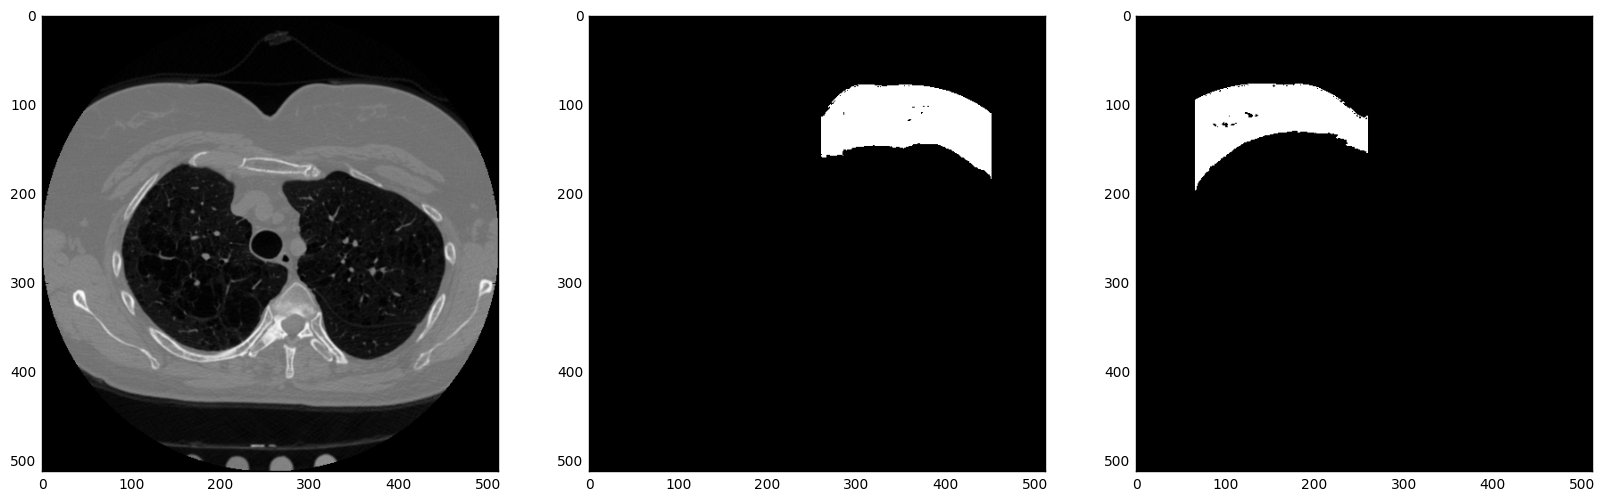

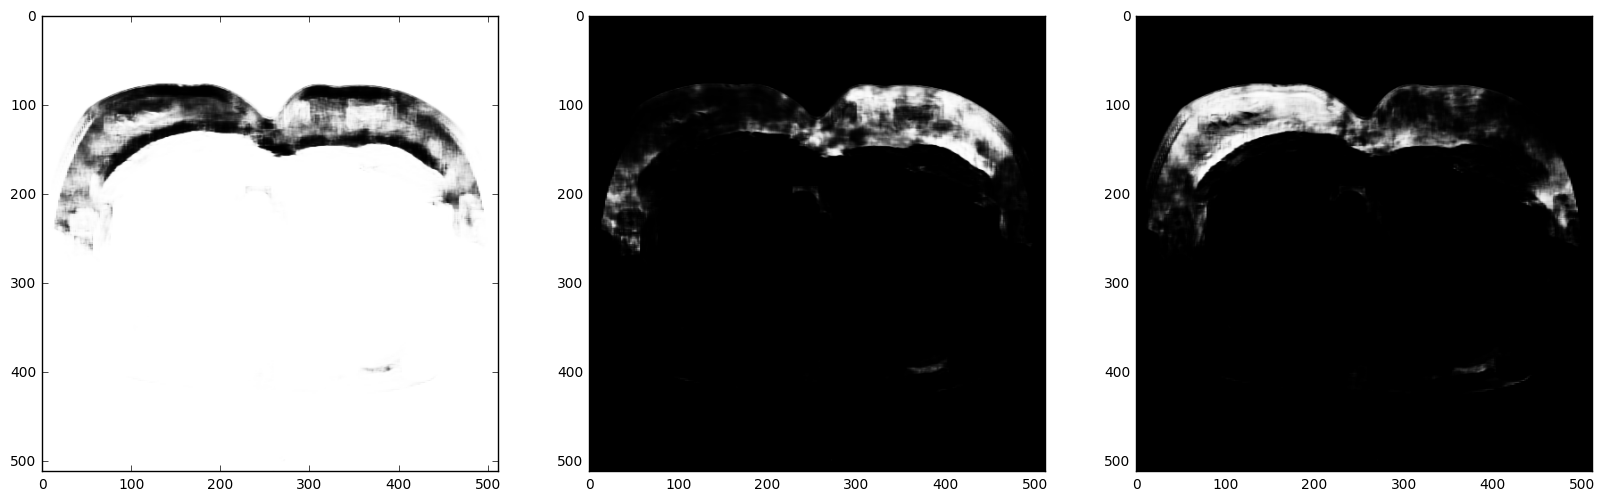

In [32]:
for i in [1]:
    f, a = plt.subplots(1, 3, figsize=(20, 20))
    f2, a2 = plt.subplots(1, 3, figsize=(20, 20))
    a[1].imshow(imgs_mask_test[i,:,:,1], cmap='Greys_r')
    a[2].imshow(imgs_mask_test[i,:,:,2], cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0], cmap='Greys_r')
    a2[0].imshow(imgs_mask_pred[i,:,:,0], cmap='Greys_r')
    a2[1].imshow(imgs_mask_pred[i,:,:,1], cmap='Greys_r')
    a2[2].imshow(imgs_mask_pred[i,:,:,2], cmap='Greys_r')
    f.show()
    f2.show()
    plt.draw()

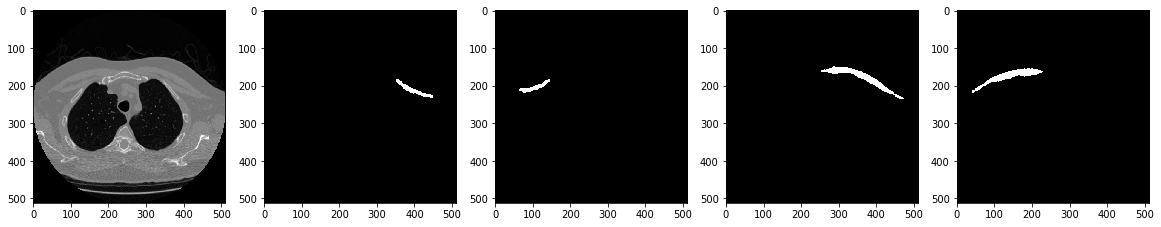

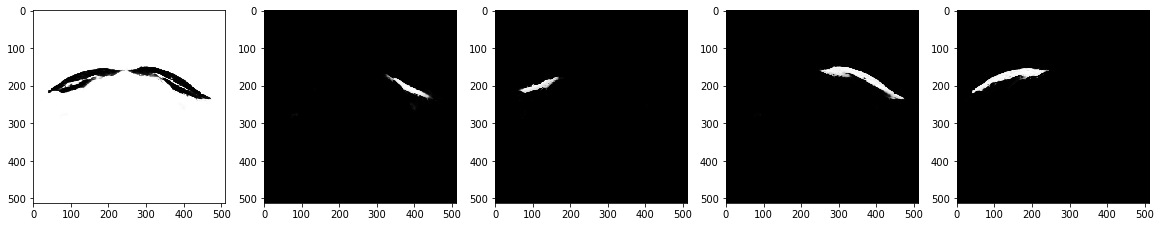

In [25]:
for i in [5]:
    f, a = plt.subplots(1, num_classes, figsize=(20, 20))
    f2, a2 = plt.subplots(1, num_classes, figsize=(20, 20))
    a[1].imshow(imgs_mask_test[i,:,:,1], cmap='Greys_r')
    a[2].imshow(imgs_mask_test[i,:,:,2], cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0], cmap='Greys_r')
    a[3].imshow(imgs_mask_test[i,:,:,3], cmap='Greys_r')
    a[4].imshow(imgs_mask_test[i,:,:,4], cmap='Greys_r')
    
    a2[0].imshow(imgs_mask_pred[i,:,:,0], cmap='Greys_r')
    a2[1].imshow(imgs_mask_pred[i,:,:,1], cmap='Greys_r')
    a2[2].imshow(imgs_mask_pred[i,:,:,2], cmap='Greys_r')
    a2[3].imshow(imgs_mask_pred[i,:,:,3], cmap='Greys_r')
    a2[4].imshow(imgs_mask_pred[i,:,:,4], cmap='Greys_r')
    f.show()
    f2.show()
    plt.draw()

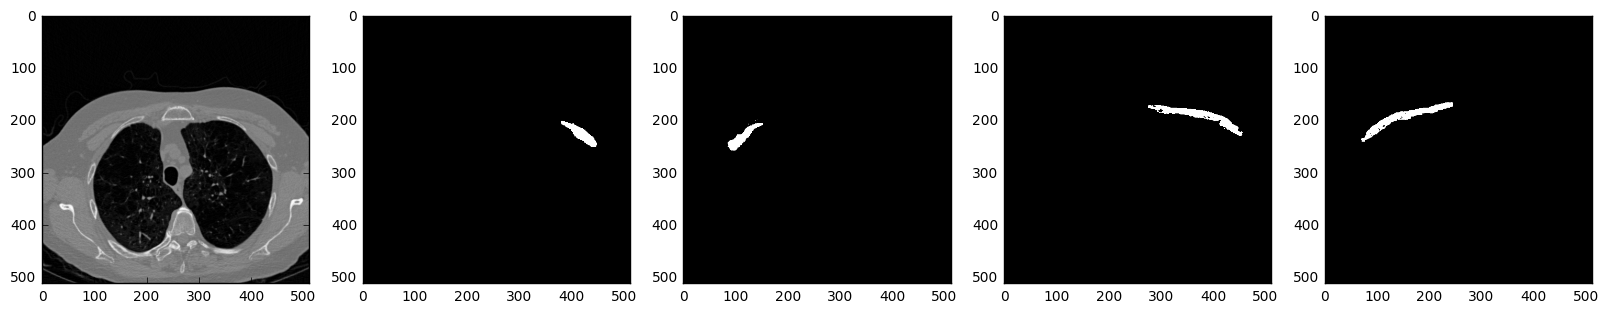

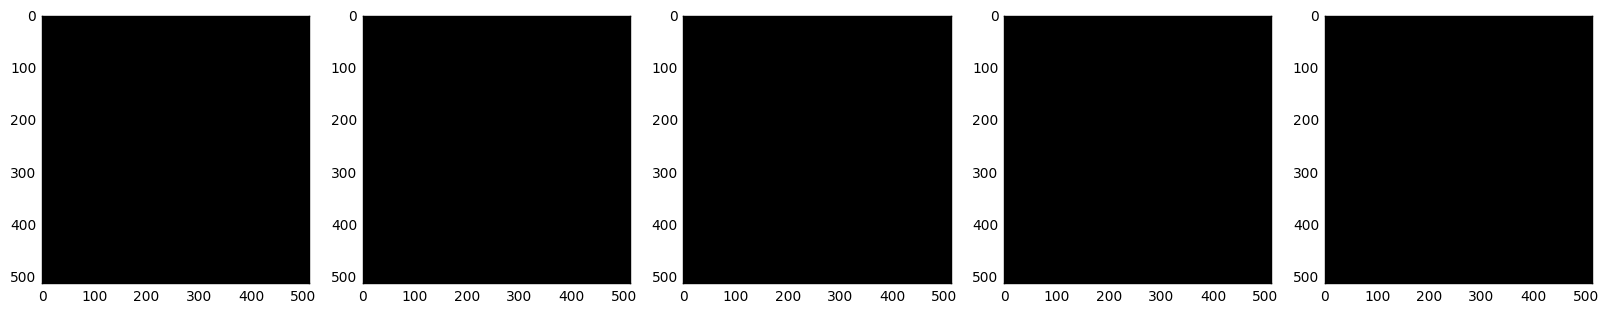

In [22]:
for i in [2]:
    f, a = plt.subplots(1, num_classes, figsize=(20, 20))
    f2, a2 = plt.subplots(1, num_classes, figsize=(20, 20))
    a[1].imshow(imgs_mask_test[i,:,:,1], cmap='Greys_r')
    a[2].imshow(imgs_mask_test[i,:,:,2], cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0], cmap='Greys_r')
    a[3].imshow(imgs_mask_test[i,:,:,3], cmap='Greys_r')
    a[4].imshow(imgs_mask_test[i,:,:,4], cmap='Greys_r')
    
    a2[0].imshow(imgs_mask_pred[i,:,:,0], cmap='Greys_r')
    a2[1].imshow(imgs_mask_pred[i,:,:,1], cmap='Greys_r')
    a2[2].imshow(imgs_mask_pred[i,:,:,2], cmap='Greys_r')
    a2[3].imshow(imgs_mask_pred[i,:,:,3], cmap='Greys_r')
    a2[4].imshow(imgs_mask_pred[i,:,:,4], cmap='Greys_r')
    f.show()
    f2.show()
    plt.draw()

In [ ]:
import scipy.misc

*Join Together*

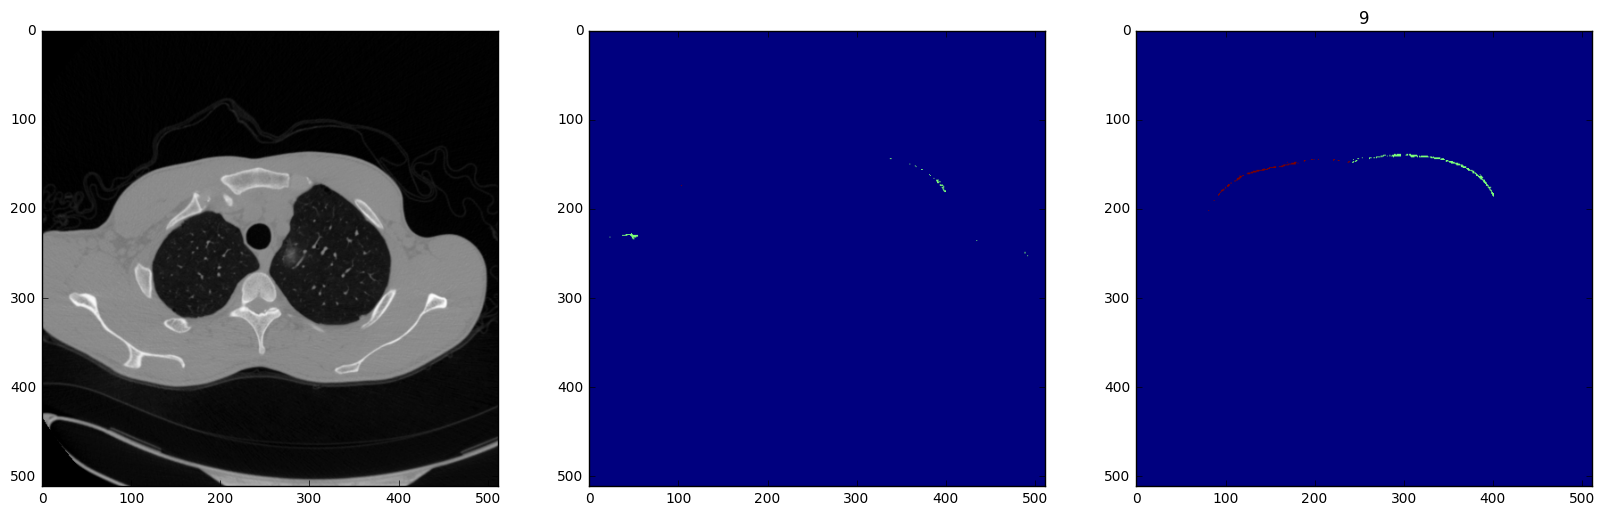

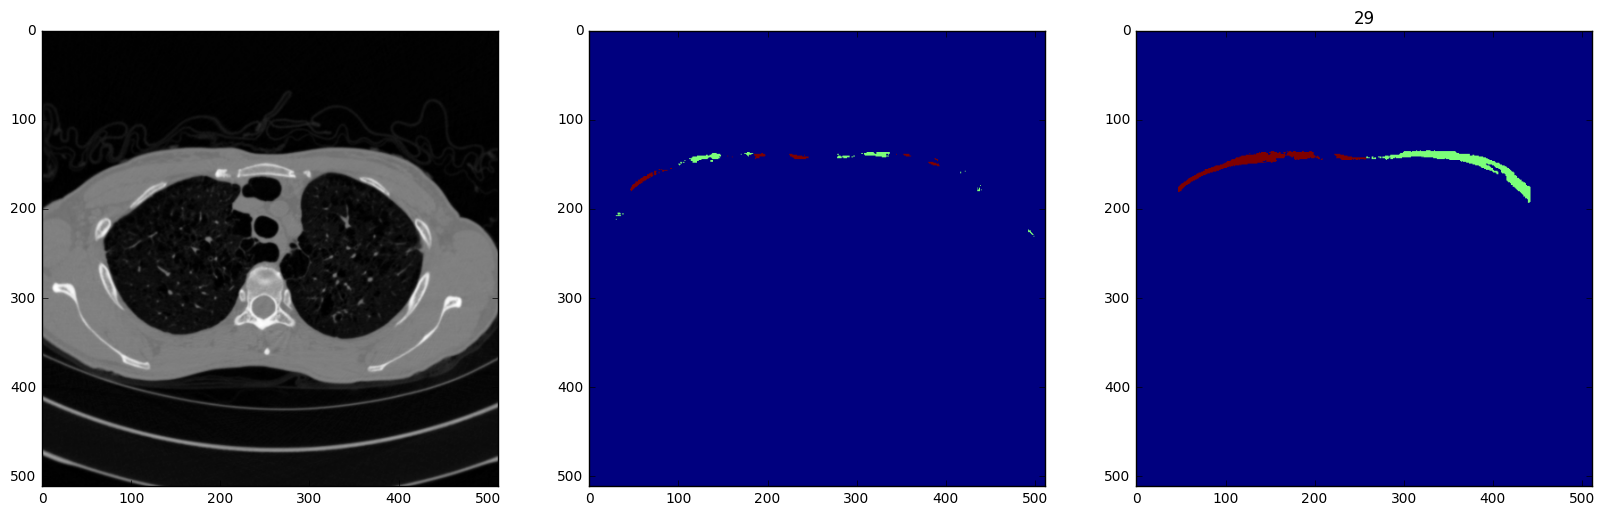

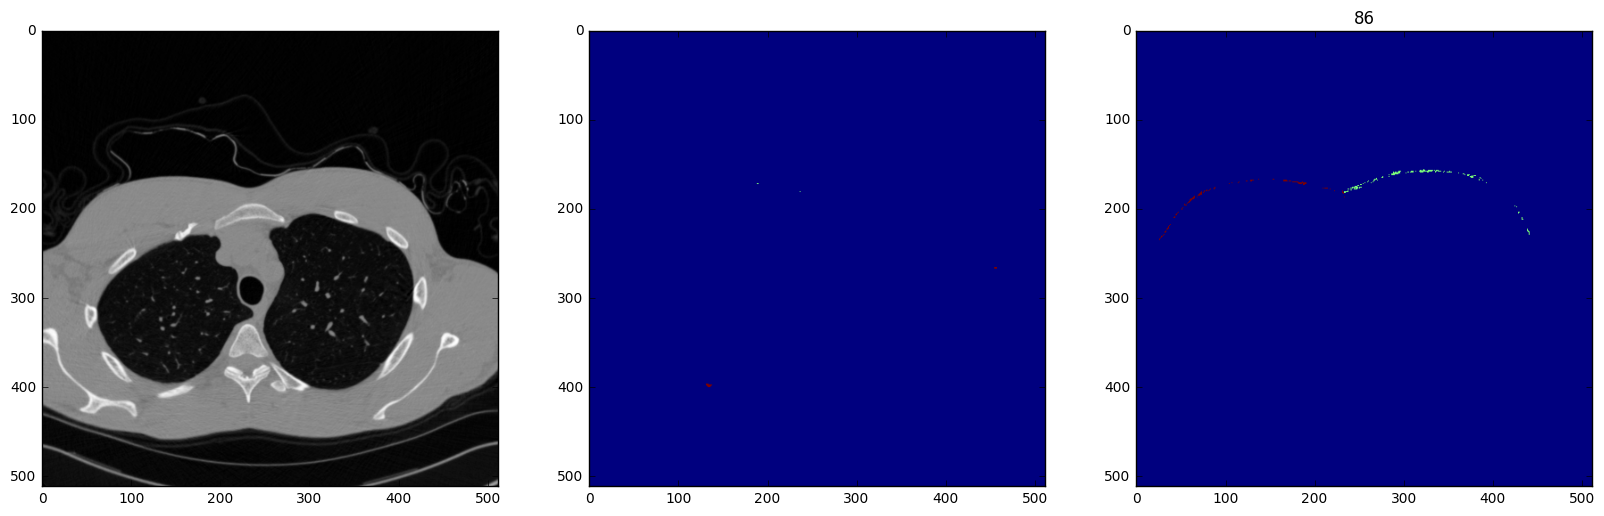

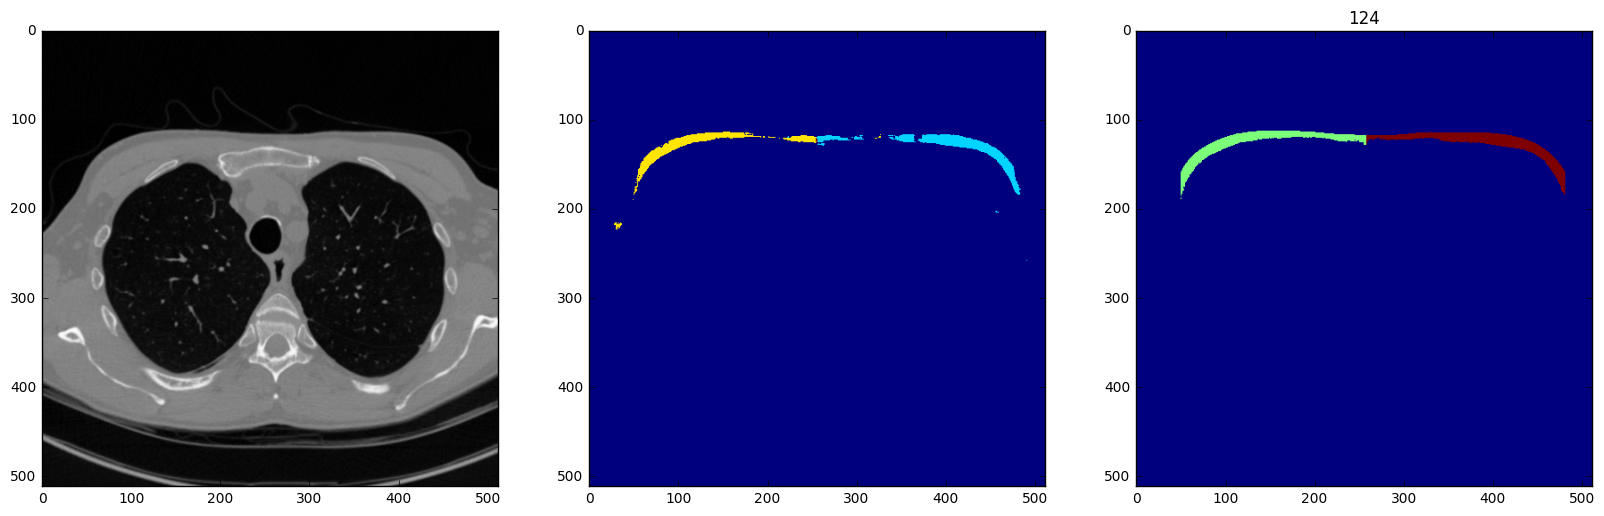

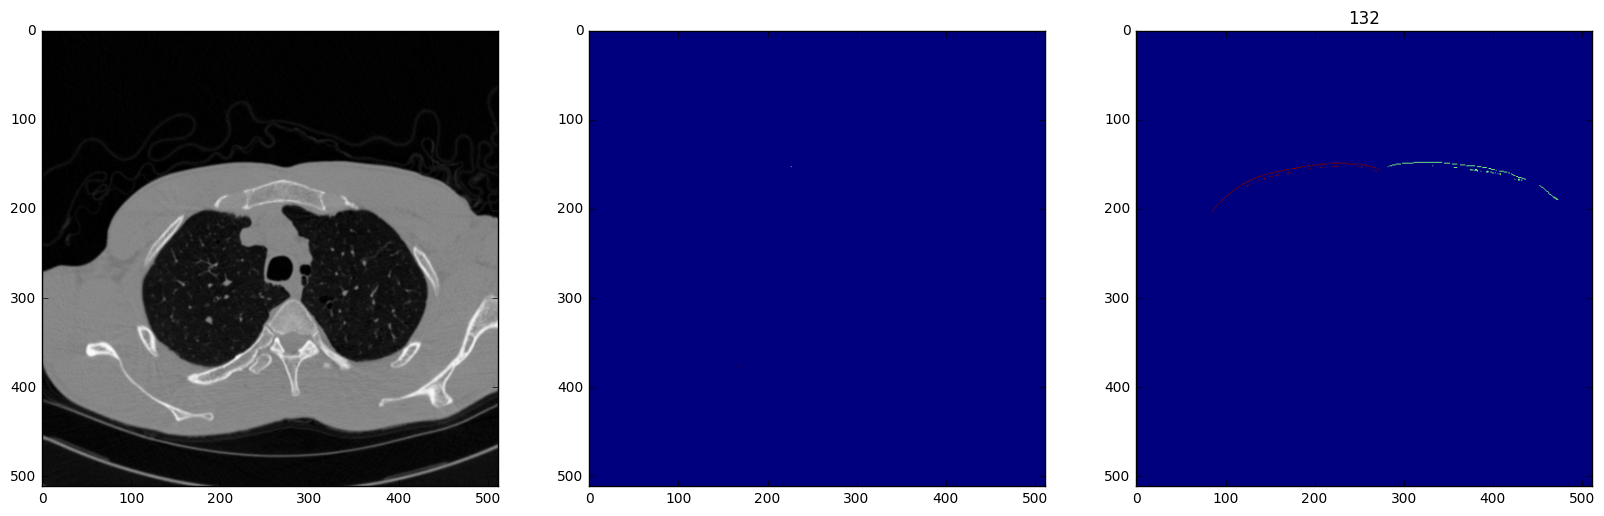

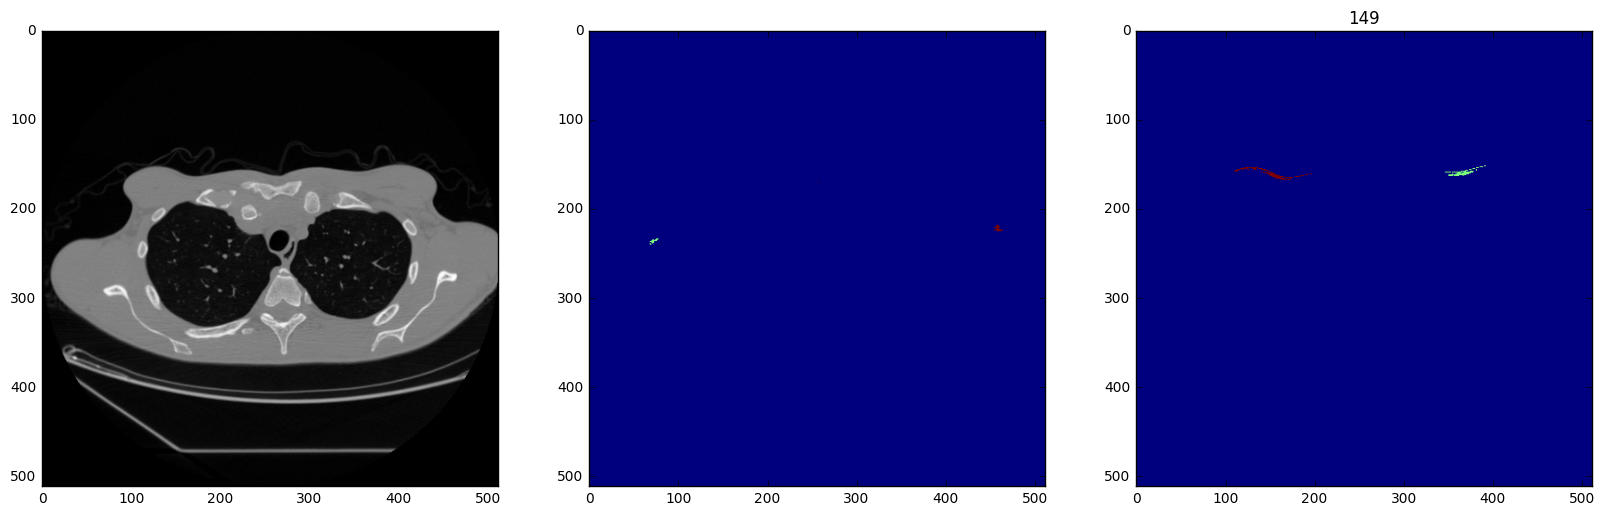

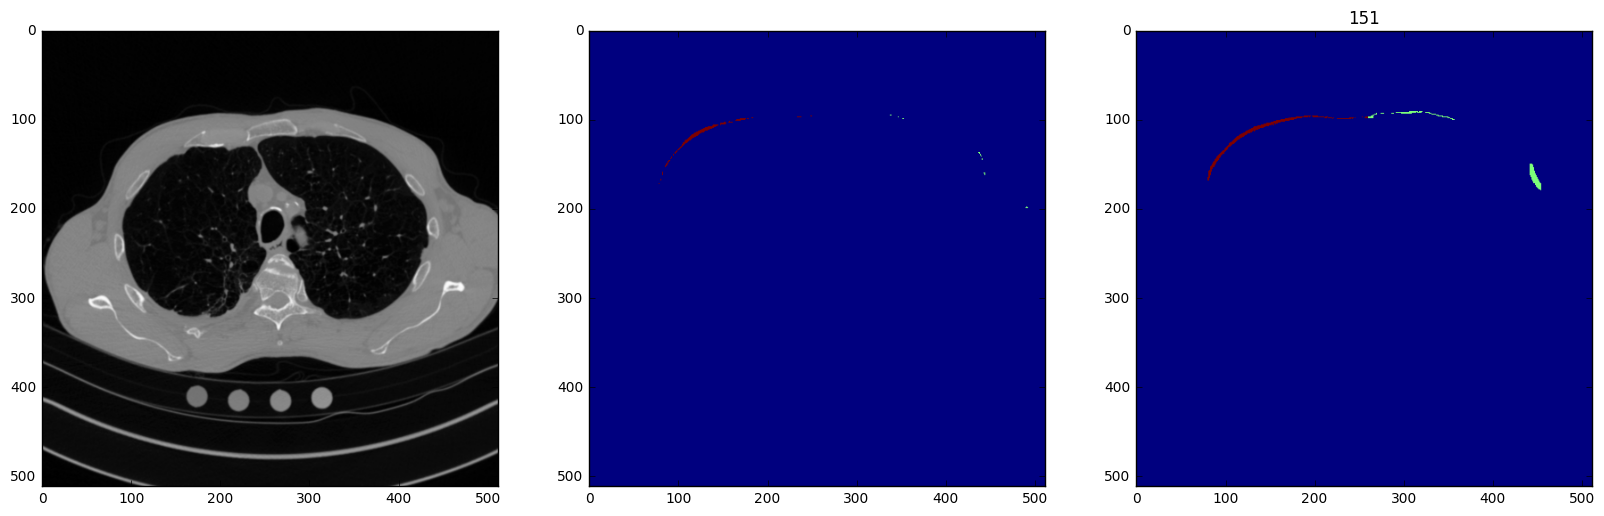

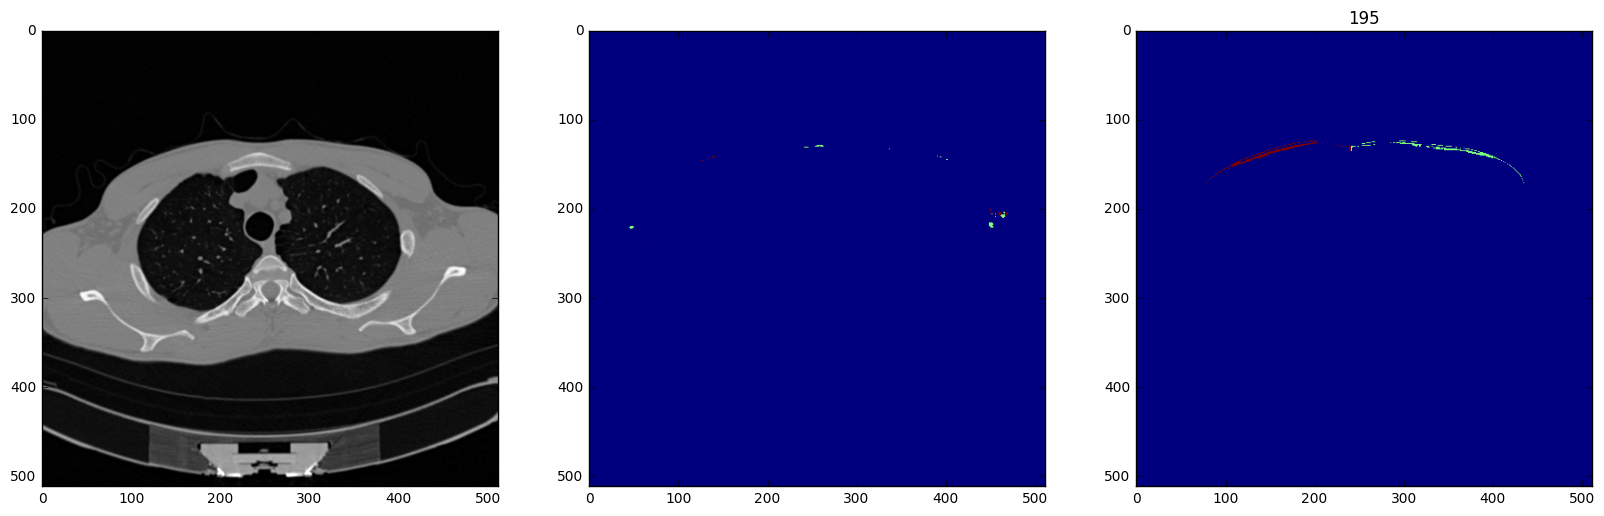

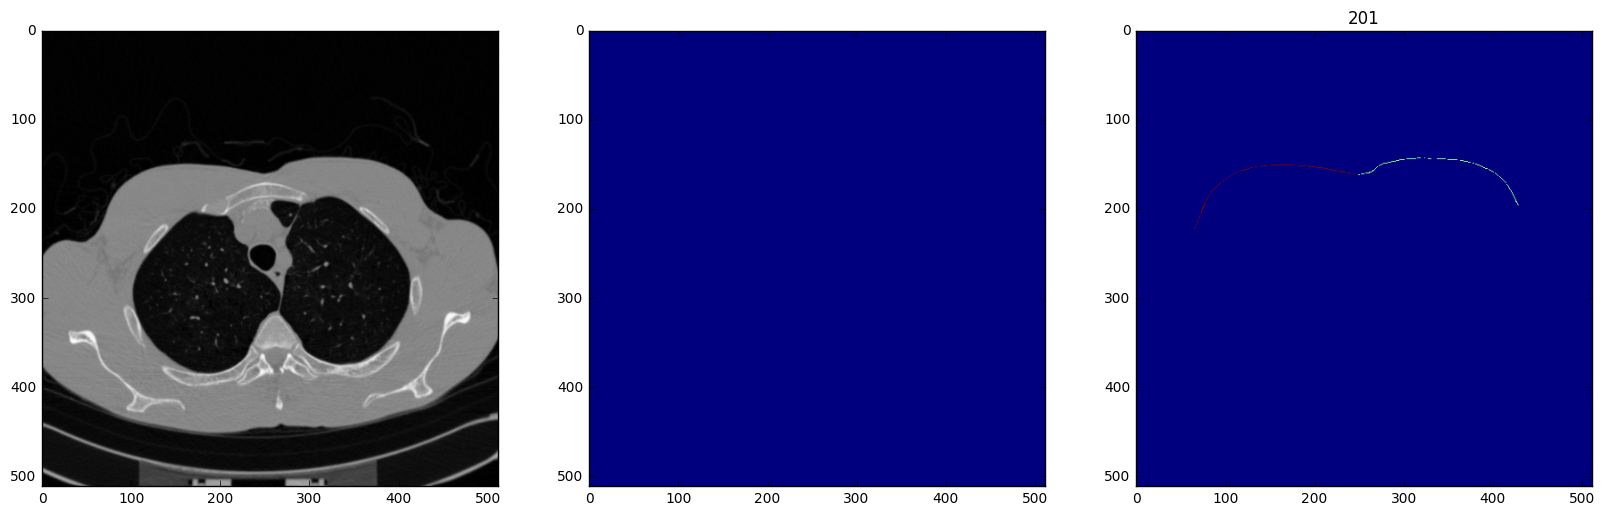

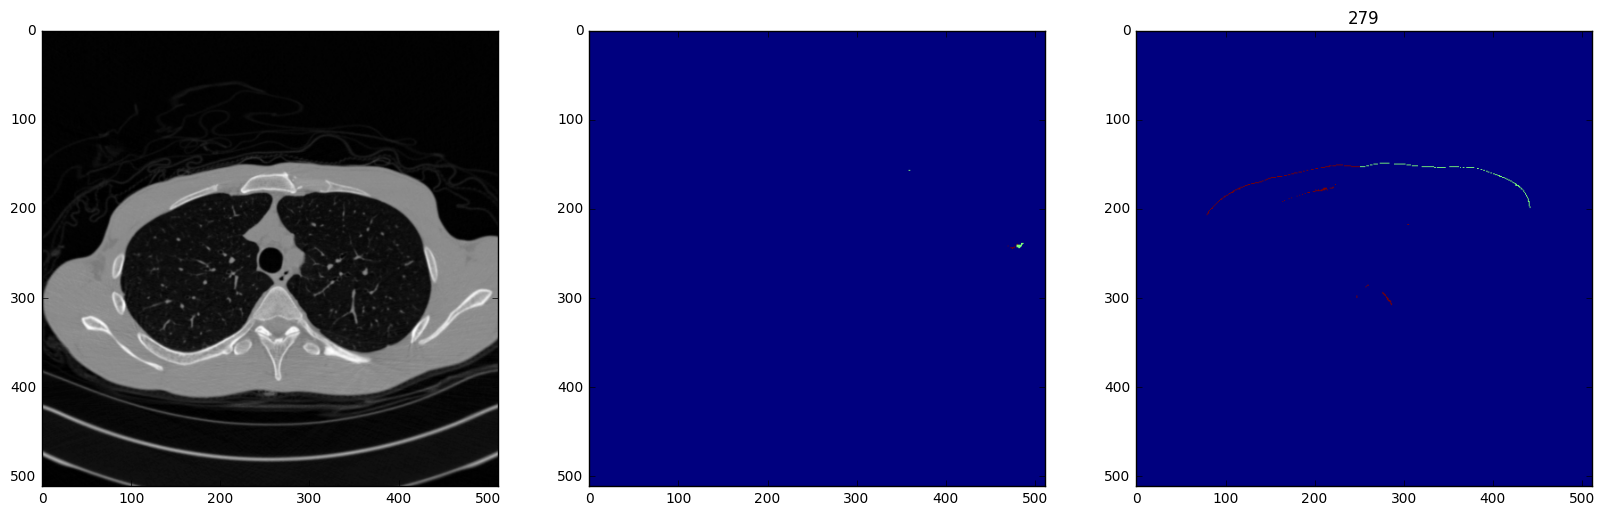

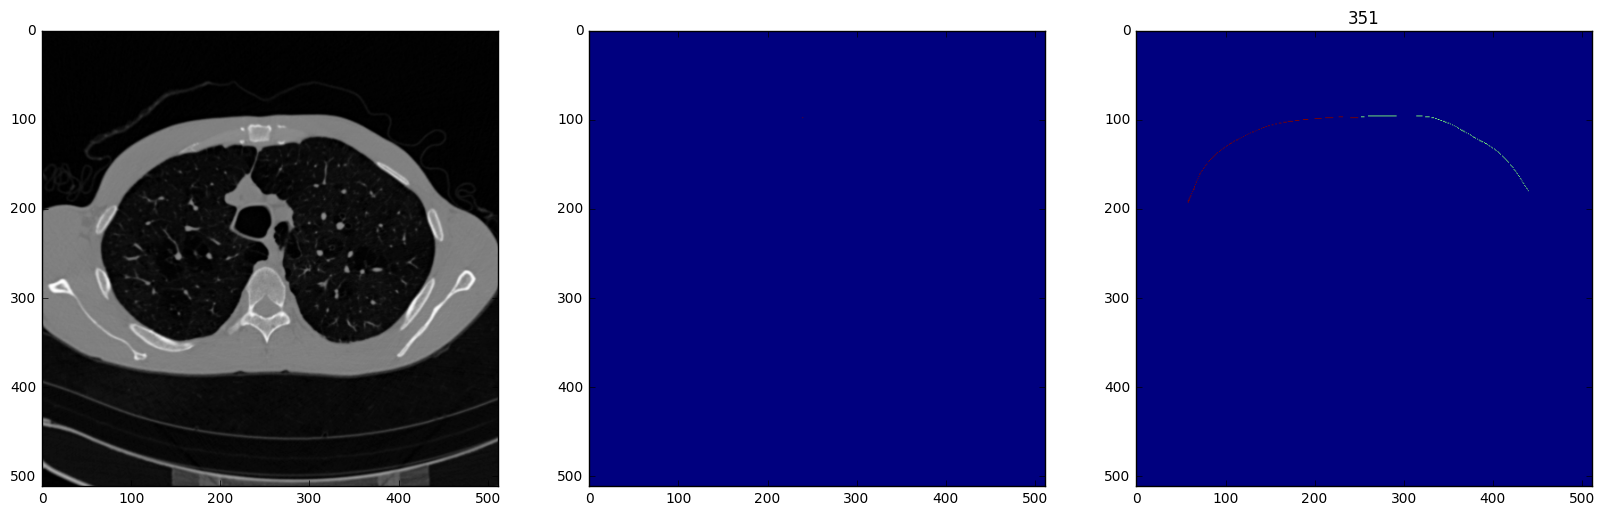

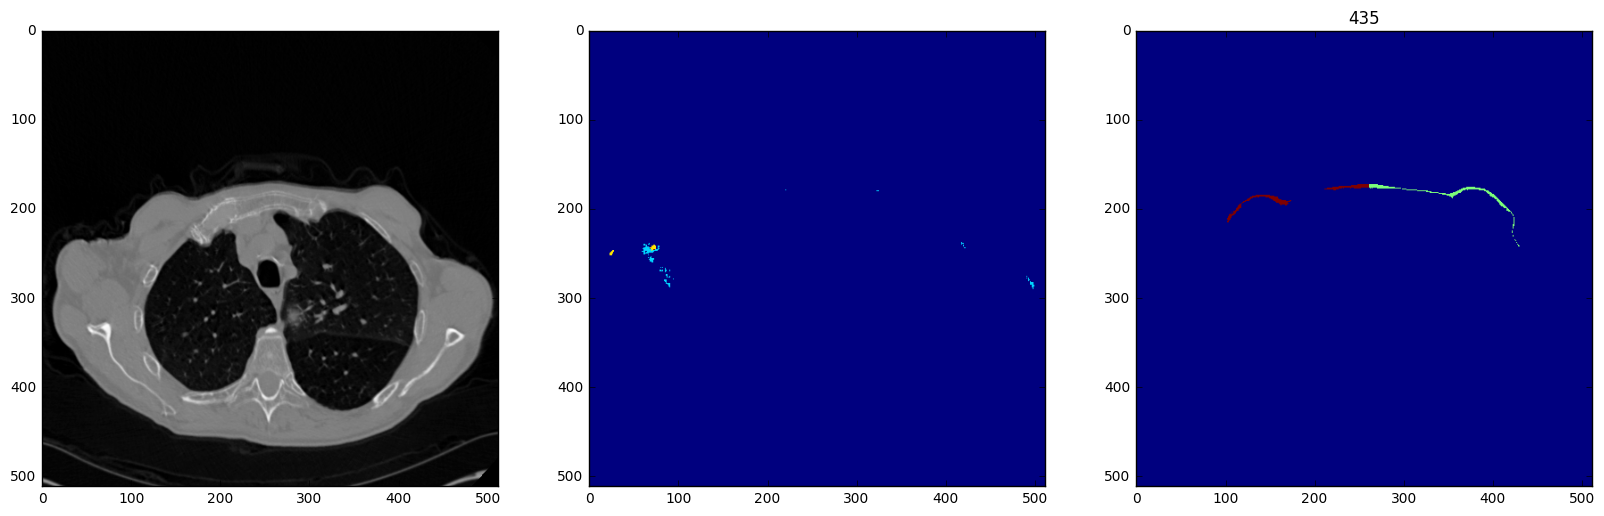

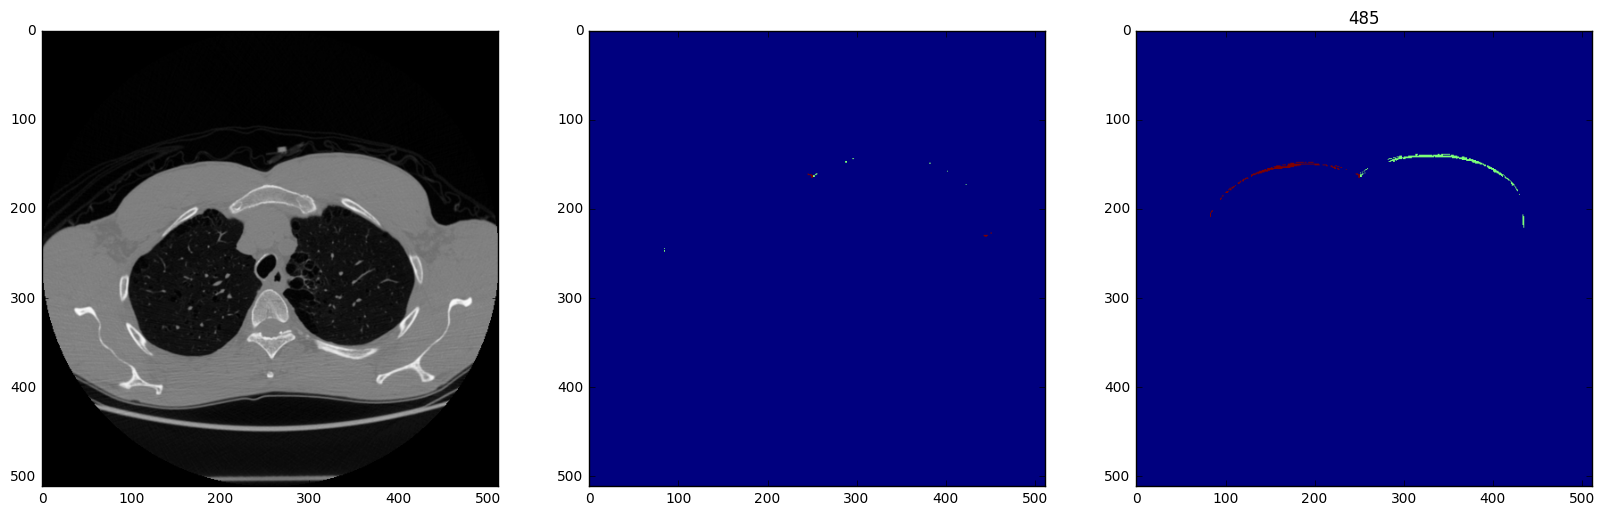

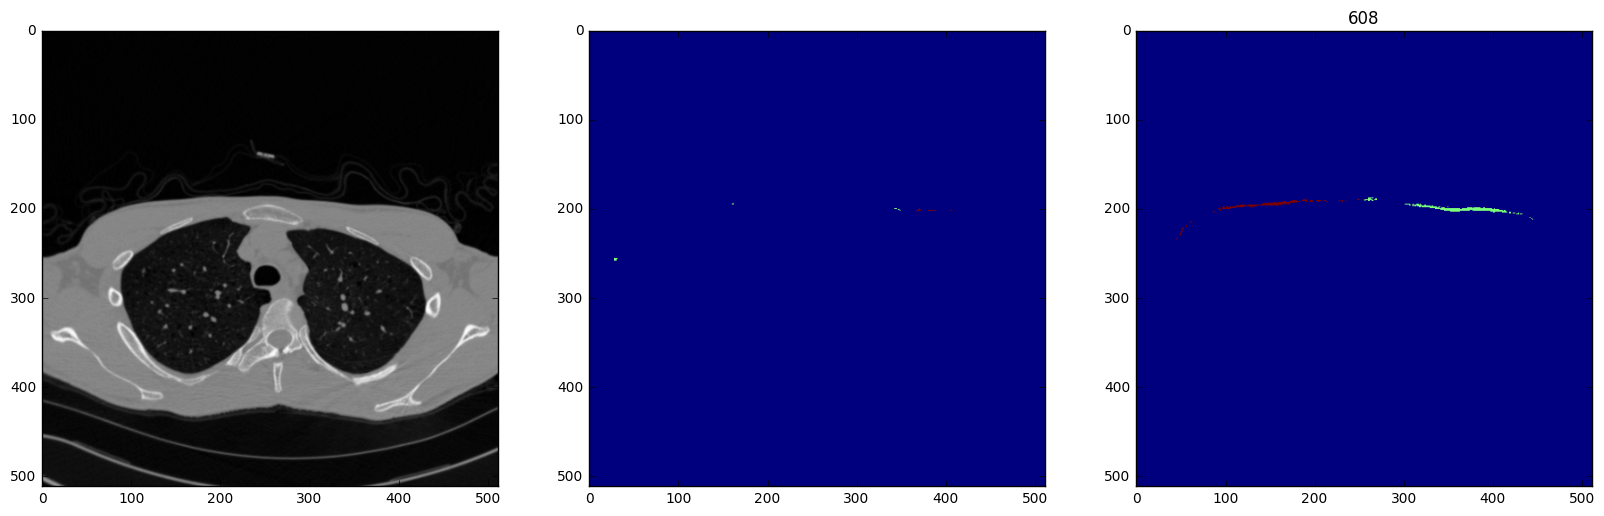

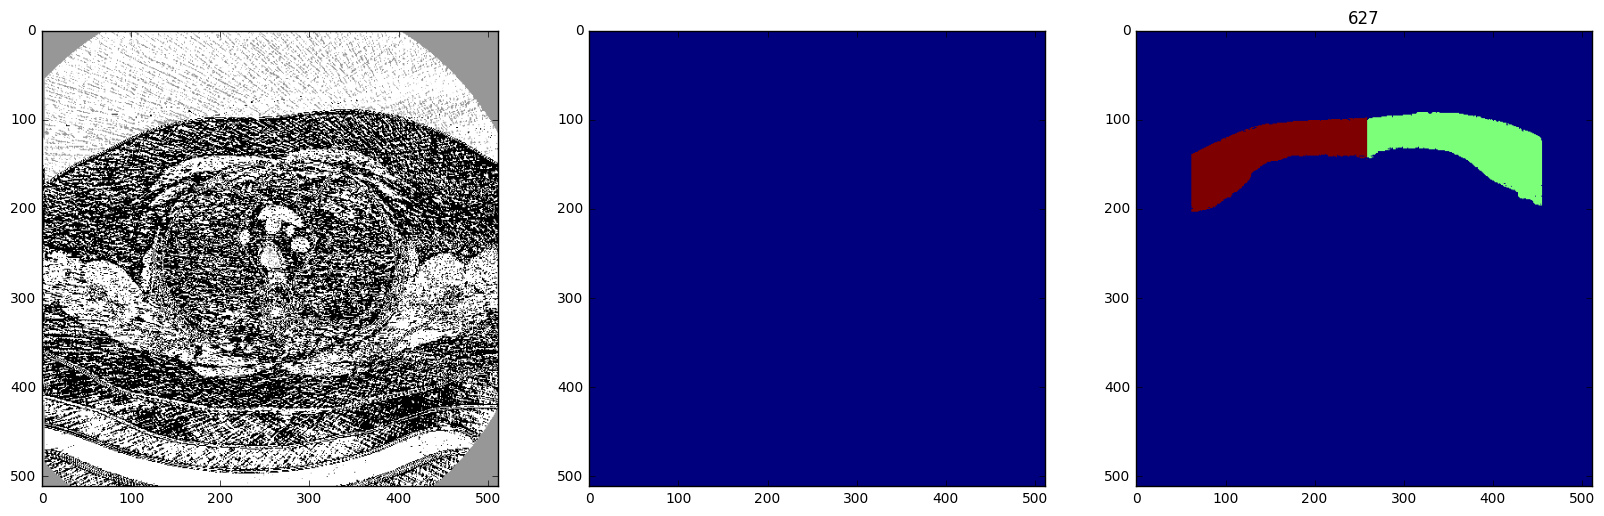

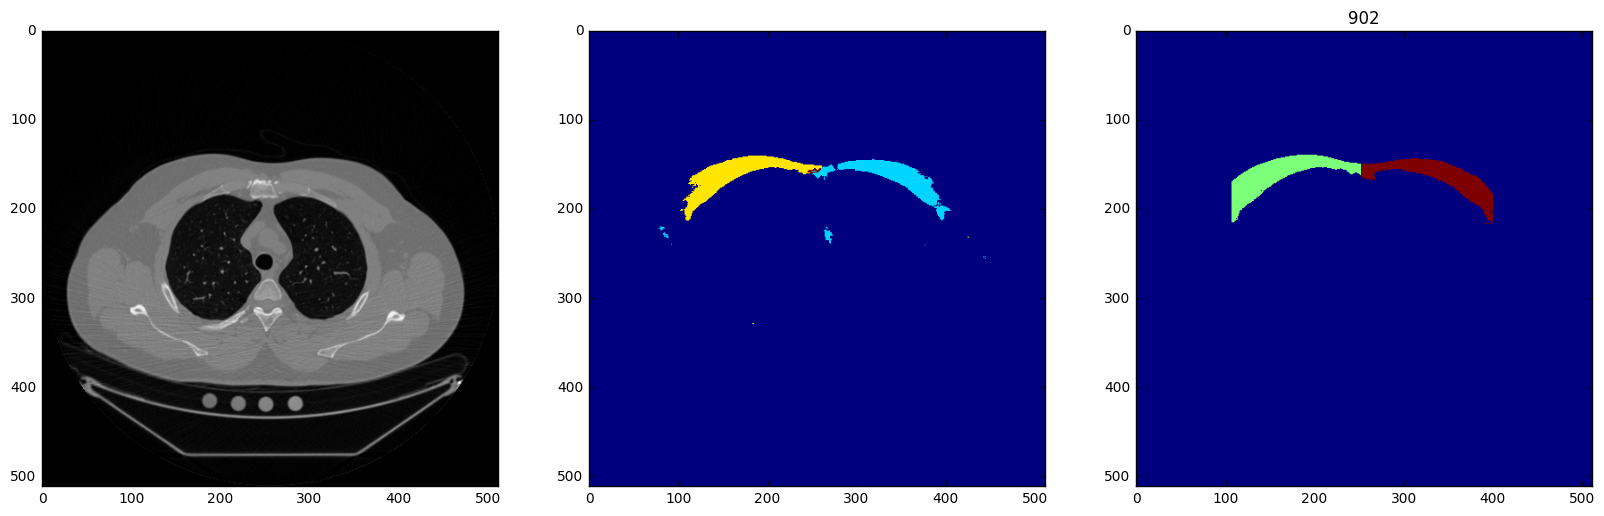

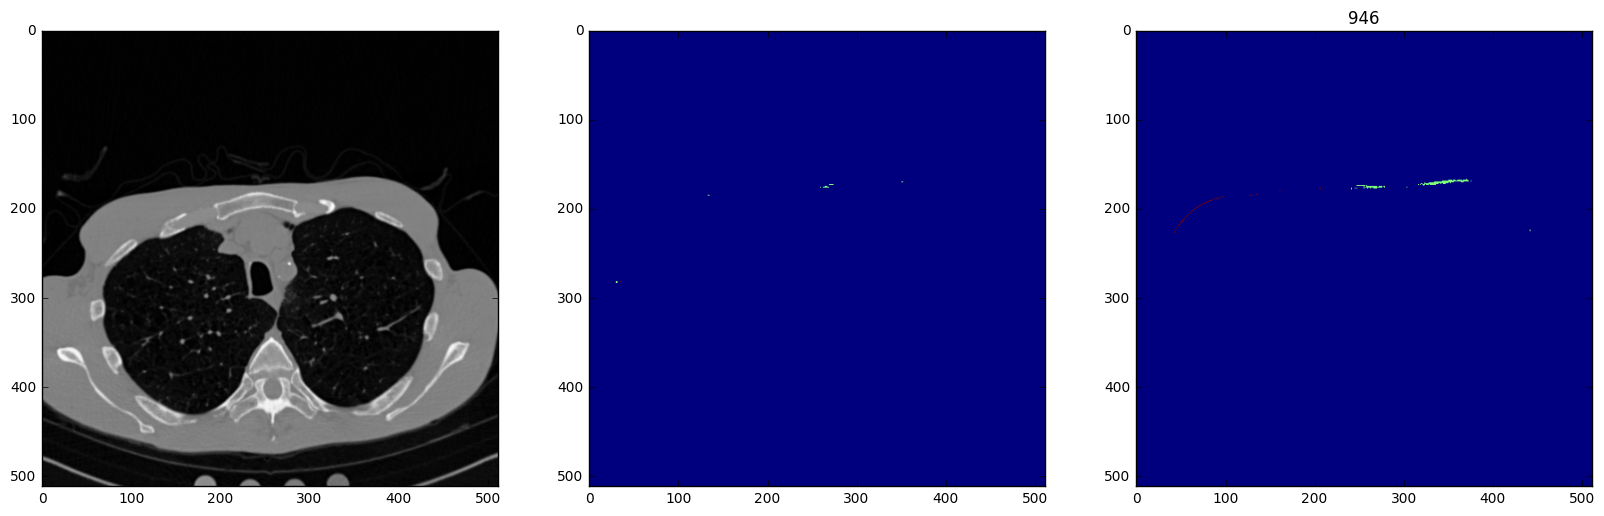

In [25]:
imgs_mask_pred_join = np.copy(imgs_mask_pred)
imgs_mask_pred_join[:,:,:,2] = imgs_mask_pred_join[:,:,:,2]*2
#imgs_mask_pred_join[:,:,:,3] = imgs_mask_pred_join[:,:,:,3]*3
#imgs_mask_pred_join[:,:,:,4] = imgs_mask_pred_join[:,:,:,4]*4
imgs_mask_pred_join = np.sum(imgs_mask_pred_join[:,:,:,1:num_classes], axis = 3)

for i in images_bad_c1:
    f, a = plt.subplots(1, 3, figsize=(20, 20))
    a[1].imshow(imgs_mask_pred_join[i,:,:])
    a[2].imshow(labels[num_images_train+i,:,:])
    a[0].imshow(imgs_test[i,:,:,0],cmap='Greys_r')
    f.show()
    plt.title(str(i))
    plt.draw()
    #plt.savefig('Figures/Multiclass/Best/all_subplot_{}.png'.format(i))
    #scipy.misc.imsave('Figures/Multiclass/Best/all_mask_pred_{}.png'.format(i),imgs_mask_pred[i,:,:,0])
    #scipy.misc.imsave('Figures/Multiclass/Best/all_test_{}.png'.format(i),imgs_mask_test[i,:,:,0])
    #scipy.misc.imsave('Figures/Multiclass/Best/all_mask_test{}.png'.format(i),imgs_test[i,:,:,0])

In [ ]:
imgs_mask_pred_join = np.copy(imgs_mask_pred)
imgs_mask_pred_join[:,:,:,2] = imgs_mask_pred_join[:,:,:,2]*2
imgs_mask_pred_join = np.sum(imgs_mask_pred_join[:,:,:,1:3], axis = 3)

for i in [0]:
    f, a = plt.subplots(1, 3, figsize=(20, 20))
    a[1].imshow(imgs_mask_pred_join[i,:,:], cmap='Greys_r')
    a[2].imshow(labels[num_images_train+i,:,:],cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0],cmap='Greys_r')
    f.show()
    plt.draw()

--------

** Accuracy over all test images**

In [17]:
def accuracy_IoU_np_all(y_true, y_pred):
    tp = np.sum(y_true * y_pred)
    fn = np.sum((y_true + y_pred)*y_true) - tp*2.
    fp = np.sum((y_true + y_pred)*y_pred) - tp*2.
    
    #beta = 1
    #F_b = ((1+np.power(beta,2))*tp)/((1+np.power(beta,2))*tp + np.power(beta,2)*fn + fp)
    IoU = (tp)/(tp + fn + fp)
    
    return IoU

In [18]:
def accuracy_IoU_np(y_true, y_pred):
    axis = np.array((2,1,0))
    tp = np.apply_over_axes(np.sum,(y_true * y_pred), axes=axis)
    fn = np.apply_over_axes(np.sum,((y_true + y_pred)*y_true), axes=axis) - tp*2.
    fp = np.apply_over_axes(np.sum,((y_true + y_pred)*y_pred), axes=axis) - tp*2.
    
    #beta = 1
    #F_b = ((1+np.power(beta,2))*tp)/((1+np.power(beta,2))*tp + np.power(beta,2)*fn + fp)
    IoU = (tp)/(tp + fn + fp)
    return IoU

('Test Accuracy Class 0: ', 0.98652244)
('Test Accuracy Class 1: ', 0.70656794)
('Test Accuracy Class 2: ', 0.68240845)
('Test Accuracy Class Mean ', 0.79183292)
('Test Accuracy Over all ', 0.9708055792769712)


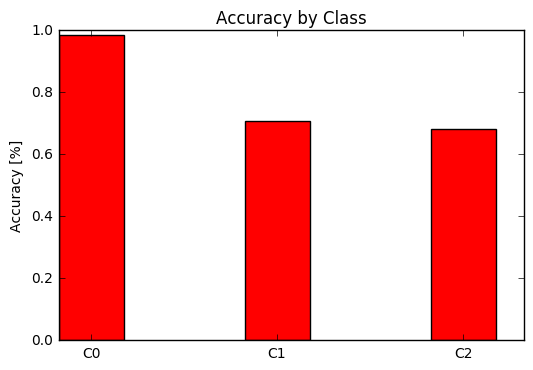

In [19]:
th = 0.5
imgs_mask_pred = np.load('imgs_mask_pred_test.npy')
imgs_mask_pred[(imgs_mask_pred>th)] = 1
imgs_mask_pred[(imgs_mask_pred<th)] = 0

acc_test = accuracy_IoU_np(imgs_mask_test,imgs_mask_pred)
acc_test = acc_test[0,0,0,:]

#print(acc_test)
for i in range(num_classes):
    print(('Test Accuracy Class ' + str(i) + ': '), acc_test[i])
print('Test Accuracy Class Mean ', np.mean(acc_test))
print('Test Accuracy Over all ', accuracy_IoU_np_all(imgs_mask_test,imgs_mask_pred))

# PLot
ind = np.arange(num_classes)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, acc_test, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy [%]')
ax.set_title('Accuracy by Class')
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(('C0', 'C1', 'C2', 'C3', 'C4'))
plt.show()
fig.savefig('Figures/Multiclass/c5_accuracy_images_barchar.png')

**Accuracy over each test image**

In [20]:
def accuracy_IoU_np_individual(y_true, y_pred):
    axis = np.array((1,2))
    tp = np.apply_over_axes(np.sum,(y_true * y_pred), axes=axis)
    fn = np.apply_over_axes(np.sum,((y_true + y_pred)*y_true), axes=axis) - tp*2.
    fp = np.apply_over_axes(np.sum,((y_true + y_pred)*y_pred), axes=axis) - tp*2.
    
    #beta = 1
    #F_b = ((1+np.power(beta,2))*tp)/((1+np.power(beta,2))*tp + np.power(beta,2)*fn + fp)
    IoU = (tp)/(tp + fn + fp)
    
    return IoU

[ 0.98710477  0.82465857  0.68372726]
('Test Accuracy Class 0: ', 0.98626024)
('Test Accuracy Class 1: ', 0.70544374)
('Test Accuracy Class 2: ', 0.68599623)


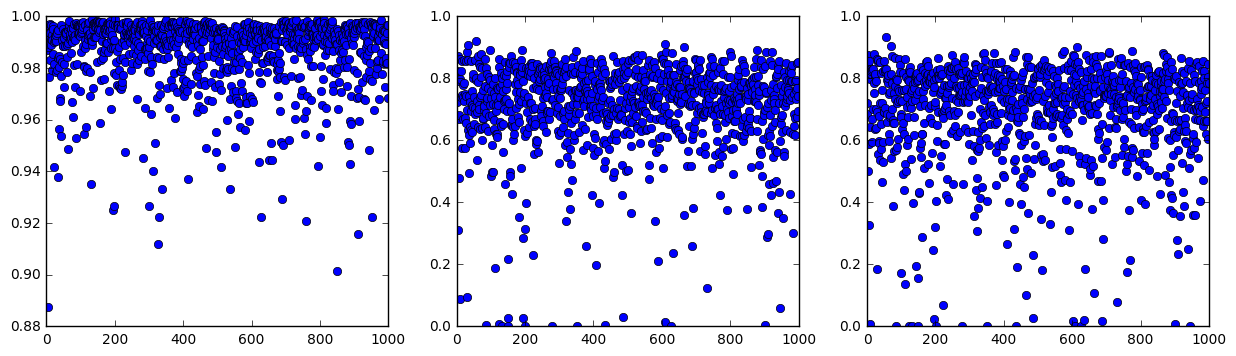

In [21]:
th = 0.5
#imgs_mask_pred = np.load('imgs_mask_pred_test.npy')
#imgs_mask_pred[(imgs_mask_pred>th)] = 1
#imgs_mask_pred[(imgs_mask_pred<th)] = 0

acc_test_image = accuracy_IoU_np_individual(imgs_mask_test,imgs_mask_pred)
print(acc_test_image[1,0,0,:])

## Plot 
images = np.arange(num_images_test)
f, a = plt.subplots(1, num_classes, figsize=(15, 4))
for i in range(num_classes):
    # Class i
    a[i].plot(images,acc_test_image[:,0,0,i], 'o')
    #a[i].xlabel('Test Images')
    #a[i].ylabel(('Accuracy Class ' + str(i)))
    #a[i].title('Accuracy for each Test Image')
    f.show()
    print(('Test Accuracy Class ' + str(i) + ': '), np.mean(acc_test_image[:,0,0,i]))
f.savefig('Figures/Multiclass/c5_accuracy_images.png')

In [23]:
# Class 1
condition = acc_test_image[:,0,0,1]<0.1
images_bad_c1 = np.where(condition)[0]
images_bad = np.where(condition)[0]
print(images_bad_c1)

# Class 2
condition = acc_test_image[:,0,0,2]<0.01
images_bad_c2 = np.where(condition)[0]
print(images_bad_c2)
images_bad = np.concatenate((images_bad, images_bad_c2))

# Class 3
#condition = acc_test_image[:,0,0,3]<0.07
#images_bad_c3 = np.where(condition)[0]
#print(images_bad_c3)
#images_bad = np.concatenate((images_bad, images_bad_c3))

# Class 4
#condition = acc_test_image[:,0,0,4]<0.1
#images_bad_c4 = np.where(condition)[0]
#print(images_bad_c4)
#images_bad = np.concatenate((images_bad, images_bad_c4))

#images_bad = np.unique(images_bad)
#print(images_bad)

# Images over all classes
acc_test_image_mean = np.mean(acc_test_image,axis=3)
condition = acc_test_image_mean[:,0,0]>0.91
images_bad_classes = np.where(condition)[0]

print(images_bad_classes)

[  9  29  86 124 132 149 151 195 201 279 351 435 485 608 627 902 946]
[  9  86 124 132 149 201 279 351 435 608 627 902 946]
[  3  20  30  33  56  72 341 601 609 613 776]


In [52]:
# Images over all classes
acc_test_image_mean = np.mean(acc_test_image,axis=3)
condition = acc_test_image_mean[:,0,0]>0.91
images_bad_classes = np.where(condition)[0]

print(images_bad_classes)

[ 16  26  78 101 117 128 206 299 391 422 492 667 675 679]


In [ ]:
#vector6 = [5,56,66,168,321,328,343,361,413,452,537,694,708,733,748,791,822,964,968,980,1028,1105,1171,1221,1227,1233,1290,1291,1399]
#vector5 = [92, 95, 145, 162, 199, 220, 236, 300, 302, 360, 403, 549, 572, 573, 591, 602, 673, 786, 821, 961, 1020, 1074, 1127, 1155, 1175]
#vector4 = [18,31,47,57,105,193,264,266,282,437,479,589,683,722,803,893,925,1097,1272,1366,1409,1410,1465,1469]
#vector3 = [15,41,64,92,128,217,229,250,287,311,314,655,663,676,694,747,960,963,1005,1075,1157,1201,1376,1401,1417,1424,1432]
#vector2 = [170,263,279,355,360,365,499,594,635,686,737,869,934,1076,1103,1108,1227,1235,1262,1330,1135,1355,1425,1468]
#vector = [1,274,386,514,644,852,859,1036,1081,1345,1353,1357,1392,1397,1438]
for i in vector:
    condition = images_bad==i
    aux = np.where(condition)[0]
    print(aux)
    print(images_bad)
    images_bad = np.delete(images_bad,aux)
    print(images_bad)

In [ ]:
wrong_images = np.array(images_bad)

np.save('wrong_slices/Cont_1_wrong_slices.npy',wrong_images)

**Test**

In [17]:
th = 0.5
imgs_mask_pred = np.load('imgs_mask_pred_test_pectoral_cars.npy')
imgs_mask_pred[(imgs_mask_pred>th)] = 1
imgs_mask_pred[(imgs_mask_pred<th)] = 0

imgs_mask_pred_fat = np.load('imgs_mask_pred_test_fat_cars.npy')
imgs_mask_pred_fat[(imgs_mask_pred_fat>th)] = 1
imgs_mask_pred_fat[(imgs_mask_pred_fat<th)] = 0

In [20]:
labels_closed = np.zeros((1400, 512, 512))

condition = imgs_mask_pred_fat[:,:,:,1]==1
aux = np.where(condition)
labels_closed[aux] = 6

condition = imgs_mask_pred_fat[:,:,:,2]==1
aux = np.where(condition)
labels_closed[aux] = 5

condition = imgs_mask_pred[:,:,:,4]==1
aux = np.where(condition)
labels_closed[aux] = 4

condition = imgs_mask_pred[:,:,:,3]==1
aux = np.where(condition)
labels_closed[aux] = 3

condition = imgs_mask_pred[:,:,:,2]==1
aux = np.where(condition)
labels_closed[aux] = 2

condition = imgs_mask_pred[:,:,:,1]==1
aux = np.where(condition)
labels_closed[aux] = 1

np.unique(labels_closed)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.])

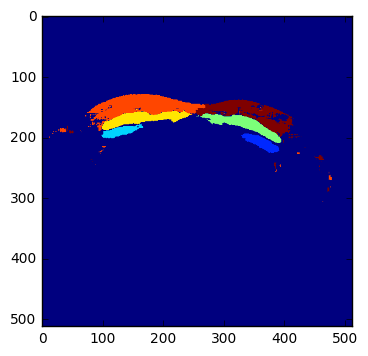

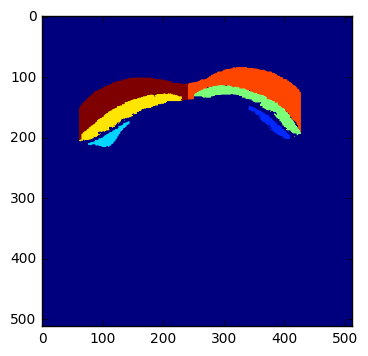

In [21]:
plt.figure()
plt.imshow(labels_closed[0,:,:])

plt.figure()
plt.imshow(labels[100,:,:])

In [19]:
imgs_mask_pred.shape

(1400, 512, 512, 5)

In [ ]:
for i in images_bad_c1:
    f, a = plt.subplots(1, 3, figsize=(20, 20))
    a[1].imshow(imgs_mask_pred_join[i,:,:])
    a[2].imshow(labels[num_images_train+i,:,:])
    a[0].imshow(imgs_test[i,:,:,0],cmap='Greys_r')
    f.show()
    plt.title(str(i))
    plt.draw()
    #plt.savefig('Figures/Multiclass/Best/all_subplot_{}.png'.format(i))
    #scipy.misc.imsave('Figures/Multiclass/Best/all_mask_pred_{}.png'.format(i),imgs_mask_pred[i,:,:,0])
    #scipy.misc.imsave('Figures/Multiclass/Best/all_test_{}.png'.format(i),imgs_mask_test[i,:,:,0])
    #scipy.misc.imsave('Figures/Multiclass/Best/all_mask_test{}.png'.format(i),imgs_test[i,:,:,0])